In [23]:
study_number = '01'
resolution = '256x256'



prefix_path = '/content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/'
study_prefix_path = prefix_path + 'gan_experiment_'+ study_number + '/'

path_to_bs = prefix_path+'bs_aug/'

path_to_sum = prefix_path + 'orig_aug/'
path_to_mask = prefix_path + 'mask_aug/'
path_to_mask_dilated = prefix_path + 'mask_aug_dilated/'

dataset_prefix = study_prefix_path + 'ds_256/'
train_path = dataset_prefix+'train/'
test_path = dataset_prefix+'test/'
validation_path = dataset_prefix+'validation/'
generated_path = dataset_prefix+'generated/'
ds_complete_path = dataset_prefix+'ds_complete/'

In [2]:
import os
import pathlib
import time
import datetime
import zipfile
import tqdm
from tqdm.contrib import tzip

import matplotlib.image as mpimg
import numpy as np

from matplotlib import pyplot as plt
from IPython import display
from statistics import mean


In [ ]:
# os.mkdir(dataset_prefix+'generated/')

FileNotFoundError: ignored

In [3]:
os.listdir(dataset_prefix)

['ds_complete', 'train', 'test', 'validation', 'generated']

####Import and define constants

In [4]:
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256
steps_gan = 45000
height, width = IMG_HEIGHT, IMG_WIDTH

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [24]:
generated_path

'/content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/ds_256/generated/'

In [25]:
!rm -rf /content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/ds_256/generated/*

####Defining utils functions

In [10]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [11]:
def load2(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    input_image = tf.cast(image, tf.float32)
    return input_image

In [12]:
def load3(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    real_image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [14]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [15]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [16]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [17]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
      # Random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [18]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [19]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                    IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image, image_file

In [20]:
def generate_images(model, test_input, tar, name_img):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', name_img]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

###Load model and transform images

In [21]:
# import os
os.listdir(generated_path)

[]

In [ ]:
# !rm -rf /content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/ds_256/generated/*

In [26]:
len(os.listdir(test_path))

184

In [27]:
try:
    validation_ds = tf.data.Dataset.list_files(test_path+'*.png')
except tf.errors.InvalidArgumentError:
    validation_ds = tf.data.Dataset.list_files(test_path+'*.png')
validation_ds = validation_ds.map(load_image_test)
validation_ds = validation_ds.batch(BATCH_SIZE)

In [28]:
study_prefix_path + 'model_'+study_number

'/content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/model_01'

In [29]:
mG = tf.keras.models.load_model(study_prefix_path + 'model_'+study_number)

In [30]:
for inp, tar, name  in tqdm.notebook.tqdm(validation_ds):
    name_img = str(name.numpy()[0]).split('/')[-1].split('.')[0]
    # generate_images(mG, inp, tar, name_img)
    prediction = mG(inp, training=True)
    # print(name)
    # print(name_img)
    tf.keras.preprocessing.image.save_img(generated_path + name_img + '.png', prediction[0])
    # break

  0%|          | 0/184 [00:00<?, ?it/s]

###Metrics

In [31]:
def msef(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

In [32]:
ssim_vec = list()
msssim_vec = list()
psnr_vec = list()
mse_vec = list()
for image in tqdm.notebook.tqdm(os.listdir(generated_path)):
    gt = test_path + image
    predicted = generated_path + image
    if (os.path.exists(gt) and os.path.exists(predicted)):
        # print(gt)
        # print(predicted)
         # Read images (of size 255 x 255) from file.
        try:
          _, real_image = load(gt)
          pred = load2(predicted)
        except:
          pass
        # print(real_image.get_shape())
        # print(pred.get_shape())
        tf.shape(real_image)  # `img1.png` has 3 channels; shape is `(255, 255, 3)`
        tf.shape(pred)  # `img2.png` has 3 channels; shape is `(255, 255, 3)`
        # Add an outer batch for each image.
        im1 = tf.expand_dims(real_image, axis=0)
        im2 = tf.expand_dims(pred, axis=0)
        # Compute SSIM over tf.uint8 Tensors.
        ssim1 = tf.image.ssim(im1, im2, max_val=255, filter_size=11,
                              filter_sigma=1.5, k1=0.01, k2=0.03)

        # Compute SSIM over tf.float32 Tensors.
        im1 = tf.image.convert_image_dtype(im1, tf.float32)
        im2 = tf.image.convert_image_dtype(im2, tf.float32)

        # ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,
                              # filter_sigma=1.5, k1=0.01, k2=0.03)

        msssim = tf.image.ssim_multiscale(im1, im2, max_val=255, filter_size=11,
                                          filter_sigma=1.5, k1=0.01, k2=0.03)

        psnr = tf.image.psnr(im1, im2, max_val=255, name=None)

        mse_vec.append(msef(im1.numpy()[0], im2.numpy()[0]))

        ssim_vec.append(ssim1.numpy()[0])
        msssim_vec.append(msssim.numpy()[0])
        psnr_vec.append(psnr.numpy()[0])
        # print(psnr.numpy()[0])





print("ssim: " + str(mean(ssim_vec)))
print("msssim: " + str(mean(msssim_vec)))
print("psnr: " + str(mean(psnr_vec)))
print("mse: " + str(mean(mse_vec))) # esta errada...

  0%|          | 0/184 [00:00<?, ?it/s]

ssim: 0.91281986
msssim: 0.92597395
psnr: 22.303137
mse: 2314.2858953890595


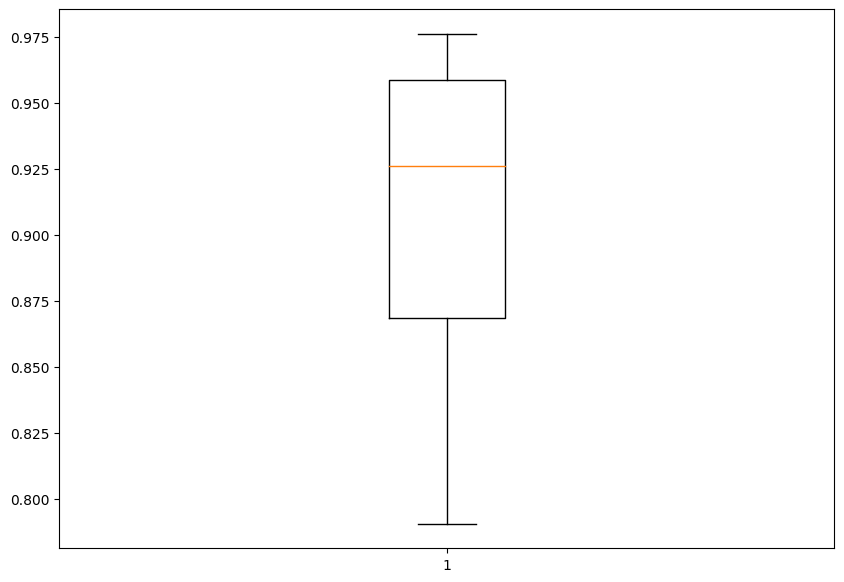

In [33]:
fig = plt.figure(figsize =(10, 7))
# Creating plot
plt.boxplot(ssim_vec)
# show plot
plt.show()

###Concat Images

In [ ]:
import tqdm
import os
import cv2
from google.colab.patches import cv2_imshow
import PIL

In [ ]:
# !mkdir /content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/ds_256/sum_images/

In [ ]:
destiny_sum_images = "/content/drive/MyDrive/ColabNotebooks/Lakehead_study/bones_mask_ds/gan_experiment_01/ds_256/sum_images/"

In [ ]:
def slow(original, predicted):
    img = original.copy()
    height, width, depth = predicted.shape
    for i in range(0, height):
        for j in range(0, (width)):
            for k in range(0, depth):
                if (predicted[i,j,k] > 0):
                    img[i,j,k] = predicted[i,j,k]
                    # print(original[i,j,k])
                # break
            # break
        # break

    return img

In [ ]:
def change_brightness(image, alpha=1, beta=0):
    new_image = np.zeros(image.shape, image.dtype)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            for c in range(image.shape[2]):
                new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)

    return new_image

In [ ]:
def mix_pixel(pix_1, pix_2, perc):
    return (perc/255 * pix_1) + ((255 - perc)/255 * pix_2)

def blend_images_using_mask(img_orig, img_for_overlay, img_mask):

    # turn mask into 24 bit greyscale image if necessary
    # because mix_pixel() requires numpy arrays having the same dimension
    # if image is 24-bit BGR, the image has 3 dimensions, if 8 bit greyscale 2 dimensions

    if len(img_mask.shape) != 3:
        img_mask = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    # interpolate between two images (img_orig and img_to_insert)
    # using the values in img_mask (each pixel serves as individual weight)
    # as weighting factors (ranging from [0,0,0] to [255,255,255] or 0 to 100 percent);
    # because all three images are numpy arrays standard operators
    # for multiplication etc. will be applied to all values in arrays

    img_res = mix_pixel(img_orig, img_for_overlay, img_mask)
    return img_res.astype(np.uint8)

In [ ]:
import skimage.exposure

def adjust_bright(img3):
    gray3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
    blur3 = cv2.GaussianBlur(gray3, (0,0), sigmaX=6, sigmaY=6)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45,45))
    morph3 = cv2.morphologyEx(blur3, cv2.MORPH_CLOSE, kernel)
    thresh3 = cv2.threshold(morph3, 0, 255, cv2.THRESH_OTSU)[1]
    masked3 = gray3.copy()
    meanval = int(np.mean(masked3))
    contours = cv2.findContours(thresh3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 500 and area < 50000:
            cv2.drawContours(masked3, [cntr], 0, (meanval), -1)

    minval = int(np.amin(masked3))
    maxval = int(np.amax(masked3))
    result3 = skimage.exposure.rescale_intensity(gray3, in_range=(minval,maxval), out_range=(0,255)).astype(np.uint8)
    # print(result3.shape)
    return np.dstack([result3]*3)


Read the input
- Convert to grayscale
- blur
- Apply morphology close
Threshold
- Get contours and exclude too small ones and too large ones so that one selects the label.
- Draw a filled contour on a copy of the grayscale image of value equal to the mean of the grayscale image in order to cover over the label
- Use Skimage to stretch the min and max values to 0 and 255 respectively. - If you do not need to bias the min or max, then you can replace (minval,maxval) with 'image'. It will automatically compute the minval and maxval and you will not need to use Numpy to find them.

In [ ]:
import skimage.exposure

def adjust_bright2(img2):
    gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    blur2 = cv2.GaussianBlur(gray2, (0,0), sigmaX=6, sigmaY=6)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45,45))
    morph2 = cv2.morphologyEx(blur2, cv2.MORPH_CLOSE, kernel)
    thresh2 = cv2.threshold(morph2, 0, 255, cv2.THRESH_OTSU)[1]
    masked2 = gray2.copy()
    meanval = int(np.mean(masked2))
    contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 500 and area < 50000:
            cv2.drawContours(masked2, [cntr], 0, (meanval), -1)
    minval = int(np.amin(masked2))
    maxval = int(np.amax(masked2))
    print(minval, maxval)
    result2 = skimage.exposure.rescale_intensity(gray2, in_range=(minval,maxval), out_range=(0,255)).astype(np.uint8)
    # return np.dstack([result2]*3)
    return np.dstack([result2]*3)

  0%|          | 0/732 [00:00<?, ?it/s]

0 255


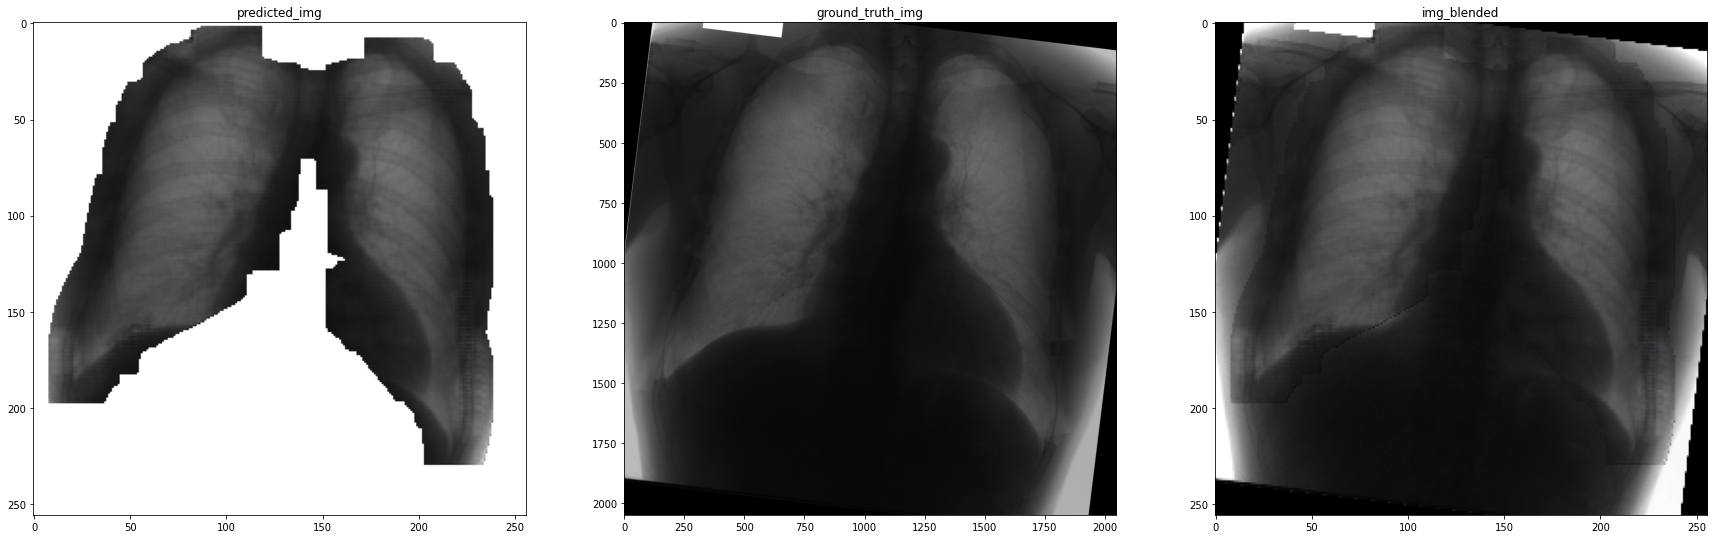

In [ ]:
for image in tqdm.notebook.tqdm(os.listdir(generated_path)):

    predicted = generated_path + image
    orig_for_sum = path_to_sum + image
    mask_for_sub = path_to_mask_dilated + image
    ground_truth = path_to_bs + image

    if (os.path.exists(predicted)):
        predicted_img = cv2.imread(predicted)
        orig_for_sum_img = cv2.imread(orig_for_sum)
        mask_for_sub_img = cv2.imread(mask_for_sub)
        ground_truth_img = cv2.imread(ground_truth)

        # mask_2 = mask_for_sub_img.copy()

        # kernel = np.ones((5, 5), np.uint8)
        # img_erosion = cv2.erode(mask_for_sub_img, kernel, iterations=4)
        # mask_for_sub_img = cv2.dilate(img_erosion, kernel, iterations=40)

        kernel2 = np.ones((3, 3), np.uint8)
        mask_for_sub_img2 = cv2.erode(mask_for_sub_img, kernel2, iterations=4)


        orig_for_sum_img = cv2.resize(orig_for_sum_img,(256,256), 0, 0, interpolation = cv2.INTER_NEAREST)
        mask_for_sub_img = cv2.resize(mask_for_sub_img,(256,256), 0, 0, interpolation = cv2.INTER_NEAREST)
        mask_for_sub_img2 = cv2.resize(mask_for_sub_img2, (256,256), 0, 0, interpolation = cv2.INTER_NEAREST)

        gen = cv2.subtract(mask_for_sub_img2, predicted_img)
        gen = cv2.bitwise_not(gen)

        # cv2.normalize(orig_for_sum_img, orig_for_sum_img, 0, 255, cv2.NORM_MINMAX)
        # res = slow(orig_for_sum_img, predicted_img)

        # orig_for_sum_img = cv2.subtract(orig_for_sum_img, res_mask)
        # alpha = 0.5
        # orig_for_sum_img = cv2.subtract(orig_for_sum_img, mask_2)
        # result_add = cv2.addWeighted(orig_for_sum_img, alpha , predicted_img, 1-alpha, 0)

        # img_blended = blend_images_using_mask(img, img_insert, img_insert_mask)
        orig_for_sum_img2 = adjust_bright(orig_for_sum_img)
        mask_for_sub_img2 = adjust_bright2(mask_for_sub_img2)

        img_blended = blend_images_using_mask(gen, orig_for_sum_img2, mask_for_sub_img2)

        # res = cv2.subtract(orig_for_sum_img, mask_2)
        # mask_2 = cv2.erode(mask_2, kernel2, iterations=1)

        # ret,  mask_thresh = cv2.threshold(mask_2, 120, 255, cv2.THRESH_BINARY)

        # res_pred = cv2.subtract(mask_thresh, predicted_img)
        # res = change_brightness(res, 1, 30)
        # final_image = slow(res, res_pred)

        fig, axs = plt.subplots(1, 3, figsize=(30, 30))
        axs[0].imshow(gen)
        axs[0].set_title("predicted_img")
        axs[0].grid(False)

        # cv2_imshow(res)
        axs[1].imshow(ground_truth_img)
        axs[1].set_title("ground_truth_img")
        axs[1].grid(False)

        # orig_mask_dilated = cv2.subtract(predicted, dilated_mask)
        axs[2].imshow(img_blended)
        axs[2].set_title("img_blended")
        axs[2].grid(False)

    break